## Context:

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

## Objective:
You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

## Dataset:
The Amazon dataset contains the following attributes:

* userId: Every user identified with a unique id
* productId: Every product identified with a unique id
* Rating: The rating of the corresponding product by the corresponding user
* timestamp: Time of the rating. We will not use this column to solve the current problem

In [1]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
# Reading the dataset
column_names = ['userId', 'productId', 'Rating', 'timestamp']
data = pd.read_csv('ratings_Electronics.csv', names = column_names, header = None)

In [3]:
data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     7824482 non-null  object 
 1   productId  7824482 non-null  object 
 2   Rating     7824482 non-null  float64
 3   timestamp  7824482 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


**Observations:**

* The rating data contains 78,24,482 observations and 4 columns.
* The 'Rating' and 'timestamp' columns are both of numeric data type.
* The **productId** & **userId**column has the data type **object**. We'll convert it to **string** format. As we will be using this column in subsequent steps.

In [5]:
# Many userId and productId contains combination of letters & digits. So we will convert the column to type 'string'
data['userId']= data['userId'].astype(str)
data['productId']= data['productId'].astype(str)

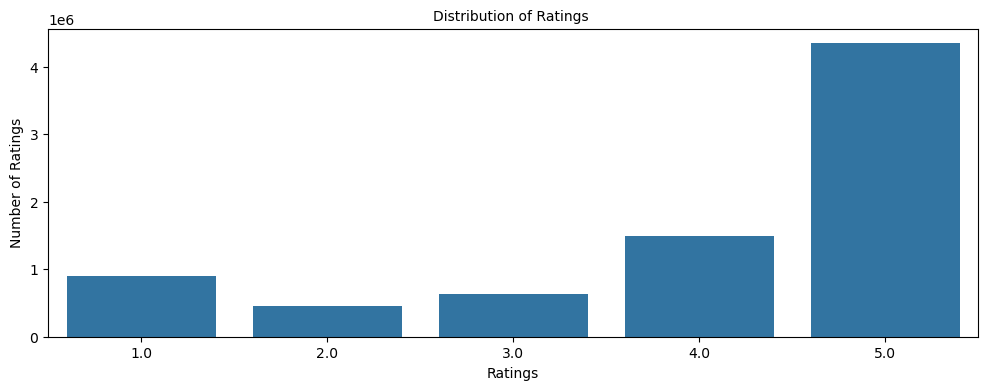

In [6]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x="Rating", data=data)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

### Observations:

- The rating **'5'** has the highest count of ratings and dominates the distribution.  
- Ratings **'1'**, **'3'**, and **'4'** have significantly fewer observations compared to **'5'**.  
- Rating **'2'** has the least number of ratings.  

In [7]:
# Finding the number of unique users
data['userId'].nunique()

4201696

In [8]:
# Finding the number of unique products
data['productId'].nunique()

476002

## Observations:

* There are 476002 products in the dataset.
* As per the number of unique users and products, there is a possibility of 476002 * 4201696 = 20,00,01,56,99,392 ratings in the dataset. But we only have 7824482 ratings, i.e., not every user has rated every product in the dataset. So, we can build a recommendation system to recommend products to users which they have not interacted with.

In [9]:
data.groupby(['userId', 'productId']).count()

Rating  timestamp
userId                productId                    
A00000262KYZUE4J55XGL B003UYU16G       1          1
A000063614T1OE0BUSKUT B00419ZT3E       1          1
                      B00432ZSHG       1          1
A00009182QVLSWIGHLS1B B009SXR7WE       1          1
A00009661LC9LQPGKJ24G B004GWQBWY       1          1
...                                  ...        ...
AZZZRS1YZ8HVP         B001CJOLBW       1          1
                      B00DR0PDNE       1          1
AZZZSIK7NFFVP         B009FU8BR0       1          1
AZZZWXXUPZ1F3         B0016CFZQ0       1          1
AZZZY1W55XHZR         B001GS8G1U       1          1

[7824482 rows x 2 columns]

In [10]:
data.groupby(['userId', 'productId']).count()['Rating'].sum()

7824482

## Observation:

* The sum is equal to the total number of observations, which implies that there is only one interaction between a book and a user.

## Which product has the highest number of reviews / ratings in the dataset?

In [11]:
data['productId'].value_counts()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B004WL91KI        1
B004WL9FK4        1
B004WL9Q2Q        1
B004WL9R8O        1
BT008V9J9U        1
Name: count, Length: 476002, dtype: int64

## Observations:

* The book with productId: B0074BW614 has been interacted by most users (18244).

* But still, there is a possibility of 4201696-18244 = 41,83,452 more interactions as we have 41,83,452 unique users in our datasets. For those 41,83,452 remaining users, we can build a recommendation system to predict who is most likely to interact with this product.

* Also, out of these 18244 interactions, we need to consider the distribution of ratings as well to check whether this product is the most liked or most disliked product.

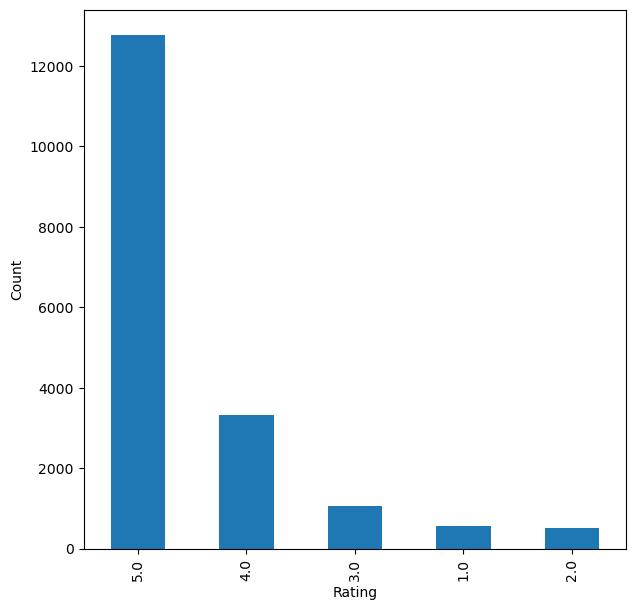

In [12]:
# Plotting distributions of ratings for the most interacted product

plt.figure(figsize=(7,7))

data[data['productId'] == 'B0074BW614']['Rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')
plt.show()

## Observations:

* We can see that the majority of the ratings for this productId are 5, followed by 4, 3, and then 2.
* Because the count of ratings 1, 2 is much lower than ratings 4 and 5, this implies that the producr is liked by the majority of users.

In [13]:
# userId = 'A5JLAU2ARJ0BO' has interacted with most of the product 
data['userId'].value_counts()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1IUWX30VMVJGP      1
A1WBP7XSZI6AUL      1
A2K7UNJHE9ZR0G      1
A1A6SIW6EWF6FP      1
A10M2KEFPEQDHN      1
Name: count, Length: 4201696, dtype: int64

## Observations:

* The user with userId: A5JLAU2ARJ0BO has interacted with the most number of products, i.e., 520 times.
* But still, there is a possibility of 476002-520 = 4,75,482 more interactions as we have 476002 unique books in the dataset.

## Data Preparation

In [14]:
# Get the column containing the users
users = data['userId']
# Create a dictionary from users to find their number of books
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [15]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
data = data.loc[~data.userId.isin(remove_users)]

In [16]:
data.shape

(125871, 4)

In [17]:
# Get the column containing the books
products = data['productId']
# Create a dictionary from books to find their number of users
ratings_count = dict()
for product in products:
    # If we already have the book, just add 1 to their rating count
    if product in ratings_count:
        ratings_count[product] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[product] = 1

In [18]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

data_final = data.loc[~ data.productId.isin(remove_users)]

In [19]:
data_final.head()

,userId,productId,Rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1322,A1A5KUIIIHFF4U,1400501466,1.0,1332547200
1335,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
1451,AW3LX47IHPFRL,1400501466,5.0,1339804800
1456,A1E3OB6QMBKRYZ,1400501466,1.0,1350086400


In [20]:
data_final.nunique()

userId       1540
productId    5689
Rating          5
timestamp    3400
dtype: int64

In [21]:
# Finding user-products interactions distribution
count_interactions = data_final.groupby('userId').count()['productId']
count_interactions

userId
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: productId, Length: 1540, dtype: int64

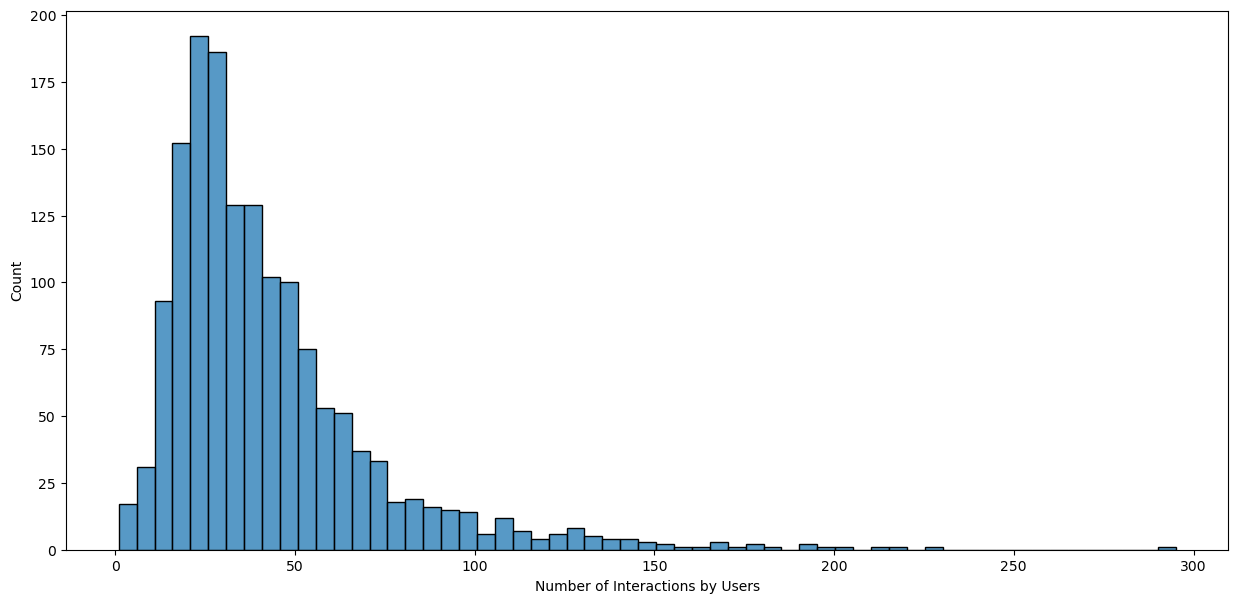

In [22]:
# Plotting user-item interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

## Observations:

* The distribution is highly skewed to the right.
* It clearly shows that there are very few products which have many ratings.

## Model 1: Create Rank-Based Recommendation System

In [23]:
# Calculating average ratings
average_rating = data_final.groupby('productId')['Rating'].mean()

# Calculating the count of ratings
count_rating = data_final.groupby('productId')['Rating'].count()

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [24]:
final_rating.head()

,avg_rating,rating_count
productId,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [25]:
final_rating['rating_count'].value_counts()

rating_count
5      1082
6       796
7       637
8       495
9       416
       ... 
90        1
167       1
71        1
72        1
82        1
Name: count, Length: 93, dtype: int64

In [26]:
def top_n_products(data, n, min_interaction=100):

    # Finding books with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

In [27]:
res = list(top_n_products(final_rating, 5, 10))
# Name of the books
list_of_products = []
for i in res:
    list_of_products.append(data_final[data_final['productId'] == str(i)]) 
list_of_products

[                 userId   productId  Rating   timestamp
 7824158  A3CW0ZLUO5X2B1  B00L3YHF6O     5.0  1405036800
 7824160    ADLVFFE4VBT8  B00L3YHF6O     5.0  1404518400
 7824163  A3AYSYSLHU26U9  B00L3YHF6O     5.0  1405296000
 7824171   A4WEZJOIZIV4U  B00L3YHF6O     5.0  1405036800
 7824191  A1EVV74UQYVKRY  B00L3YHF6O     5.0  1404604800
 7824192  A2XCCN239AR1XK  B00L3YHF6O     5.0  1404604800
 7824196  A1UQBFCERIP7VJ  B00L3YHF6O     5.0  1405900800
 7824198   AWPODHOB4GFWL  B00L3YHF6O     5.0  1404950400
 7824201  A35Q0RBM3YNQNF  B00L3YHF6O     5.0  1405555200
 7824208  A3R1WFO4KIUQXZ  B00L3YHF6O     5.0  1404691200
 7824209  A3S3R88HA0HZG3  B00L3YHF6O     5.0  1405468800
 7824212  A2XRMQA6PJ5ZJ8  B00L3YHF6O     5.0  1404950400
 7824216  A3A4ZAIBQWKOZS  B00L3YHF6O     5.0  1404691200
 7824221   AOVTLYTHVDNUX  B00L3YHF6O     5.0  1405296000,
                  userId   productId  Rating   timestamp
 3734470  A19HT7YC1UW3D6  B003ZYF3M8     5.0  1390348800
 3734484  A32T2H8150OJLU  B003

In [28]:
res2 = list(top_n_products(final_rating, 5, 100))
# Name of the books
list_of_product = []
for i in res2:
    list_of_product.append(data_final[data_final['productId'] == str(i)])
list_of_product

[                 userId   productId  Rating   timestamp
 3313486   AAXAKFQEAQPWC  B003ES5ZUU     3.0  1401580800
 3313490  A3CW0ZLUO5X2B1  B003ES5ZUU     5.0  1322870400
 3313605    ADLVFFE4VBT8  B003ES5ZUU     5.0  1292371200
 3313635  A32O98PFC3OP7K  B003ES5ZUU     5.0  1361059200
 3313779  A32QOZWIKQDNZX  B003ES5ZUU     5.0  1300320000
 ...                 ...         ...     ...         ...
 3323617  A1MFPAM9TTRTXN  B003ES5ZUU     5.0  1402185600
 3323626  A3TCMJ6GKZJFBQ  B003ES5ZUU     3.0  1292716800
 3323639  A2I2KPNJDQ9SL0  B003ES5ZUU     5.0  1365206400
 3323659  A3CG93783LP0FO  B003ES5ZUU     5.0  1385942400
 3323705   AXYM52DNK6NDF  B003ES5ZUU     5.0  1340150400
 
 [184 rows x 4 columns],
                  userId   productId  Rating   timestamp
 1198226   A9ELHLPXF7JKD  B000N99BBC     5.0  1365292800
 1198233  A19UTUEBWKIZFT  B000N99BBC     5.0  1374883200
 1198238  A2RW587355CMVA  B000N99BBC     5.0  1368748800
 1198255  A3RGHO0Q938FRS  B000N99BBC     5.0  1365379200
 119

## Model 2: Collaborative Filtering Based Recommendation System

In [29]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in the structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

In [30]:
def precision_recall_at_k(model, k=10, threshold=3.5):

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions is calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    # Mean of all the predicted recalls is calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)

    accuracy.rmse(predictions)
    print('Precision: ', precision) # Command to print the overall precision
    print('Recall: ', recall) # Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

In [31]:
from sklearn.preprocessing import LabelEncoder
df = data_final[['userId','productId']].apply(LabelEncoder().fit_transform)
df['Rating'] = data_final['Rating']
df.head(10)

,userId,productId,Rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0
1485,114,0,5.0
2082,812,1,5.0
2150,950,1,5.0
2162,1203,1,1.0
2228,272,1,4.0


In [32]:
df_rating = df.copy()

In [33]:
# Calculating average ratings
average_rating = df.groupby('productId')['Rating'].mean()

# Calculating the count of ratings
count_rating = df.groupby('productId')['Rating'].count()

# Updating the final_rating dataframe with the new encoded book_id count and average of ratings based on the new dataframe
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})
final_rating.head()

,avg_rating,rating_count
productId,,
0,3.333333,6
1,3.833333,6
2,4.000000,5
3,4.875000,8
4,5.000000,5


In [34]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['userId', 'productId', 'Rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

## User-Based Collaborative Filtering Recommendation System

In [35]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(algo_knn_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


In [36]:
df

,userId,productId,Rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0
...,...,...,...
7824423,870,5688,5.0
7824424,187,5688,5.0
7824425,462,5688,5.0
7824426,163,5688,5.0


In [37]:
algo_knn_user.predict(1310, 0, r_ui=5, verbose=True)

user: 1310       item: 0          r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=1310, iid=0, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [38]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40, 50, 60], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9719102952277919
{'k': 60, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [39]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=50, min_k=6, verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10.
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9630
Precision:  0.85
Recall:  0.809
F_1 score:  0.829


In [40]:
similarity_algo_optimized.predict(1310, 0, r_ui=5, verbose=True)

user: 1310       item: 0          r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=1310, iid=0, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

## Implementing the recommendation algorithm based on optimized KNNBasic model

In [41]:
def get_recommendations(data, userId, top_n, algo):

    # Creating an empty list to store the recommended book ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index='userId', columns='productId', values='Rating')

    # Extracting those book ids which the user_id has not interacted with yet
    non_interacted_items = user_item_interactions_matrix.loc[userId][user_item_interactions_matrix.loc[userId].isnull()].index.tolist()

    # Looping through each of the book id which user_id has not interacted with yet
    for productId in non_interacted_items:

        # Predicting the ratings for those non interacted book ids by this user
        est = algo.predict(userId, productId).est

        # Appending the predicted ratings
        recommendations.append((productId, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returning top n predicted rating items for this user

In [42]:
df_rating = df_rating.drop_duplicates()

In [43]:
recommendations = get_recommendations(df_rating, 1, 5, similarity_algo_optimized)

In [44]:
# Building the dataframe for above recommendations with columns "book_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['productId', 'predicted_ratings'])

,productId,predicted_ratings
0,53,5
1,121,5
2,472,5
3,504,5
4,579,5


In [45]:
def ranking_products(recommendations, final_rating):
  # Sort the books based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # Merge with the recommended books to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns=['productId', 'predicted_ratings']), on='productId', how='inner')

  # Rank the books based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # Sort the books based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending=False)

  return ranked_products

In [46]:
ranking_products(recommendations, final_rating)

,productId,rating_count,predicted_ratings,corrected_ratings
0,504,17,5,4.757464
1,53,16,5,4.750000
2,579,13,5,4.722650
3,472,12,5,4.711325
4,121,10,5,4.683772


## Model 3: Item based Collaborative Filtering Recommendation System

In [47]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options = sim_options,verbose = False)

# Train the algorithm on the train set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k=10
precision_recall_at_k(algo_knn_item)

RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


In [48]:
algo_knn_item.predict(1310, 0, r_ui=5, verbose=True) #change this please 

user: 1310       item: 0          r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=1310, iid=0, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [49]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [50]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(
    sim_options={'name': 'cosine', 'user_based': False}, 
    k=20, 
    min_k=6,
    verbose=False
)

# Training the algorithm on the train set
similarity_algo_optimized_item.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 0.9720
Precision:  0.835
Recall:  0.796
F_1 score:  0.815


In [51]:
similarity_algo_optimized_item.predict(1310, 0, r_ui=8, verbose=True)

user: 1310       item: 0          r_ui = 8.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=1310, iid=0, r_ui=8, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [52]:
similarity_algo_optimized_item.get_neighbors(1, k=5)

[3, 7, 9, 17, 18]

In [53]:
recommendations = get_recommendations(df_rating, 1, 5, similarity_algo_optimized_item)

In [54]:
# Building the dataframe for above recommendations with columns "book_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['productId', 'predicted_ratings'])

,productId,predicted_ratings
0,2405,5.000000
1,2201,4.873062
2,2388,4.855346
3,1462,4.850000
4,4354,4.840522


In [55]:
# Applying the ranking_books function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,productId,rating_count,predicted_ratings,corrected_ratings
2,2405,7,5.000000,4.622036
0,2388,10,4.855346,4.539118
1,2201,8,4.873062,4.519508
3,4354,7,4.840522,4.462558
4,1462,5,4.850000,4.402786


## Model 4: Matrix Factorization

In [56]:
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


In [57]:
# Making prediction for user_id 1326 and book_id 12126
svd.predict(870, 5688, r_ui=5, verbose=True)

user: 870        item: 5688       r_ui = 5.00   est = 4.69   {'was_impossible': False}


Prediction(uid=870, iid=5688, r_ui=5, est=4.687467361686603, details={'was_impossible': False})

## Improving matrix factorization based recommendation system by tuning its hyperparameters

In [58]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30], 
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8988396833496871
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


In [59]:
# Building the optimized SVD model
svd_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2, random_state=1)

# Training the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd_optimized)

RMSE: 0.8906
Precision:  0.861
Recall:  0.799
F_1 score:  0.829


In [60]:
# Making prediction for user_id 1326 and book_id 12126
svd_optimized.predict(164, 0, r_ui=1, verbose=True)

user: 164        item: 0          r_ui = 1.00   est = 3.03   {'was_impossible': False}


Prediction(uid=164, iid=0, r_ui=1, est=3.028022695595122, details={'was_impossible': False})

In [61]:
# Getting top 5 recommendations for user_id 1 using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_rating, 1, 5, svd_optimized)

In [62]:
# Ranking book based on above recommendations
ranking_products(svd_recommendations, final_rating)

,productId,rating_count,predicted_ratings,corrected_ratings
0,4886,45,4.580016,4.430945
2,2391,29,4.580954,4.395258
1,1548,31,4.500911,4.321306
3,2018,20,4.509858,4.286251
4,4580,11,4.544856,4.243344
